# Applying normal Timewise PCA

In [1]:
import seaborn as sns
import os
import pandas as pd
from matplotlib.pyplot import title

sns.set_theme(style="ticks")

In [2]:
# Load segmented data
def load_segmented_data(data_folder="", event_name=None):
    """
    Load segmented CSV data.

    Parameters:
    - data_folder (str): Folder where the segmented .csv files are stored.
    - event_name (str or None): Name of the event to load. If None, loads all CSV files.

    Returns:
    - pd.DataFrame: Loaded dataframe with all data concatenated if loading all events.
    """
    if event_name is not None:
        # Load one specific event csv
        file_path = os.path.join(data_folder, f"segment_around_{event_name}.csv")
        if not os.path.isfile(file_path):
            raise FileNotFoundError(f"No data found for event '{event_name}' at {file_path}")
        df = pd.read_csv(file_path)
        print(f"Loaded data for event '{event_name}' from {file_path}.")
        return df
    else:
        # Load all csv files in the folder that match pattern 'segment_around_*.csv'
        all_files = [f for f in os.listdir(data_folder) if f.startswith("segment_around_") and f.endswith(".csv")]
        if not all_files:
            raise FileNotFoundError(f"No segmented CSV files found in folder {data_folder}")

        dfs = []
        for file in all_files:
            path = os.path.join(data_folder, file)
            df_temp = pd.read_csv(path)
            # Optionally add a column indicating source event, parsed from filename
            event_from_file = file.replace("segment_around_", "").replace(".csv", "")
            df_temp['EventName'] = event_from_file
            dfs.append(df_temp)
        df_all = pd.concat(dfs, ignore_index=True)
        print(f"Loaded and concatenated {len(all_files)} segmented event files from {data_folder}.")
        return df_all

In [3]:
# Data path
data_folder = "data/cleaned_data/data_segment/Safak"
# Load single event:
df_single_event = load_segmented_data(data_folder=data_folder, event_name="StagEventNew_nearest_neighbor_steeringRemoved")
df_single_event
# Load all events:
# df_all = load_segmented_data(data_folder="data/data_segment")

Loaded data for event 'StagEventNew_nearest_neighbor_steeringRemoved' from data/cleaned_data/data_segment/Safak/segment_around_StagEventNew_nearest_neighbor_steeringRemoved.csv.


,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,LeftEyeIsBlinkingWorld,...,TimeStamp,TimeStamp_in_sec,TimeDiff_in_sec,Blink,BlinkDuration,BlinkDurationsLong,BlinkAfter,SamplingRate,time_from_event,outlier
0,2020-09-26 13:46:22.260000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.918274,False,False,False,...,1.601128e+09,139.759740,0.010971,False,0.106051,0.0,False,50.0,-5.00,False
1,2020-09-26 13:46:22.280000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.939484,False,False,False,...,1.601128e+09,139.781682,0.021942,False,0.105959,0.0,False,50.0,-4.98,False
2,2020-09-26 13:46:22.300000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.961914,False,False,False,...,1.601128e+09,139.803248,0.021566,False,0.105866,0.0,False,50.0,-4.96,False
3,2020-09-26 13:46:22.320000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,347.983795,False,False,False,...,1.601128e+09,139.825190,0.016456,False,0.105774,0.0,False,50.0,-4.94,False
4,2020-09-26 13:46:22.340000+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,348.000427,False,False,False,...,1.601128e+09,139.841646,0.016705,False,0.105681,0.0,False,50.0,-4.92,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80155,2020-09-19 10:22:15.060000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.885681,False,False,True,...,1.600511e+09,170.287970,0.009973,False,NaN,0.0,False,50.0,4.92,False
80156,2020-09-19 10:22:15.080000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.907898,False,False,True,...,1.600511e+09,170.310909,0.022938,False,NaN,0.0,False,50.0,4.94,False
80157,2020-09-19 10:22:15.100000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.919006,False,False,True,...,1.600511e+09,170.322876,0.010971,False,NaN,0.0,False,50.0,4.96,False
80158,2020-09-19 10:22:15.120000+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,MountainRoad,FullLoopAR,1.600511e+09,717.952576,False,False,True,...,1.600511e+09,170.355788,0.022938,False,NaN,0.0,False,50.0,4.98,True


In [4]:
df_single_event['uid'].nunique()

160

In [5]:
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

# Remap 'SuccessfulCompletionState'
This is important in case we want to use Success later for analysis etc.

In [6]:
# To see if all values are NaN, only 1, only 0, or mixed
result = df_single_event.groupby('uid')['SuccessfulCompletionState'].agg(
    lambda x: {
        'all_nan': x.isna().all(),
        'all_one': (x == 1).all() if not x.isna().all() else False,
        'all_zero': (x == 0).all() if not x.isna().all() else False,
        'mixed': not (x.isna().all() or (x == 1).all() or (x == 0).all())
    }
)
# To see the actual status info for each uid:
print(result)

uid
0037b2329de444c18d751b4e79901b39    {'all_nan': False, 'all_one': False, 'all_zero...
0117810eb9634c4f98f842021ee6a595    {'all_nan': False, 'all_one': False, 'all_zero...
0121f5b2f59d434f8beb17bf3e2a80b9    {'all_nan': False, 'all_one': False, 'all_zero...
0956f0cca5f546d79a0cf4fbae23d496    {'all_nan': False, 'all_one': False, 'all_zero...
09a23914cf354ea39444511406d16722    {'all_nan': False, 'all_one': False, 'all_zero...
                                                          ...                        
f9c6ff61370141c89ea9bbc536d796e1    {'all_nan': False, 'all_one': False, 'all_zero...
fa2e2604ec6a4820851f032e80f09ba1    {'all_nan': False, 'all_one': False, 'all_zero...
fa4ca90c5b80445b9af0b7ec4fbcc124    {'all_nan': False, 'all_one': False, 'all_zero...
fd19a21a4a8846ca82bd127e4e1933f5    {'all_nan': False, 'all_one': False, 'all_zero...
ff4288f304e74bbf93aa6508c7df8145    {'all_nan': False, 'all_one': False, 'all_zero...
Name: SuccessfulCompletionState, Length: 160, dtyp

In [7]:
# 1. Get the known value (0 or 1) for each uid
# First, identify the non-NaN value per 'uid' (assumes consistent non-NaN)
uid_value = df_single_event.groupby('uid')['SuccessfulCompletionState'].transform(lambda x: x.dropna().unique()[0])

# 2. Fill NaNs with the corresponding uid's value
# For entries where 'SuccessfulCompletionState' is NaN, replace with uid_value
df_single_event['SuccessfulCompletionState'] = df_single_event['SuccessfulCompletionState'].fillna(uid_value)
# To see if all values are NaN, only 1, only 0, or mixed
df_single_event['SuccessfulCompletionState']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
80155    1.0
80156    1.0
80157    1.0
80158    1.0
80159    1.0
Name: SuccessfulCompletionState, Length: 80160, dtype: float64

# 1. Apply PCA

In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import dask.array as da
import scipy as sp
from scipy.stats import chi2
import gc
import seaborn as sns
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
plt.style.use('ggplot')

### Useful functions

In [9]:
# Simple mahalanobis distance
def mahalanobis(df, no_dask=True, md_name='',outlier_name=''):
    # Calculate mean
    x_minus_mu = df - np.mean(df)
    # Calculate covariance
    cov = np.cov(df.values.T)
    # Calculate inverse covariance
    if df.shape[1] < 2:
        # Reshape when only one column in used (e.g., 'SteeringInput')
        inv_covmat = sp.linalg.inv(cov.reshape((1,1)))
    else:
        inv_covmat = sp.linalg.inv(cov)
    if no_dask:
        # No dask work only for individual UID
        left_term = np.dot(x_minus_mu, inv_covmat)
        mahal = np.dot(left_term, x_minus_mu.T)
        # Calculate md
        md = np.sqrt(mahal.diagonal())
    else:
        # Dask needs to be used when calculating md across conditions
        x_minus_mu_dask = da.from_array(x_minus_mu.to_numpy(), chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
        mahal = np.sqrt(np.diagonal(np.dot(np.dot(x_minus_mu_dask,inv_covmat), x_minus_mu_dask.T)))
        # Calculate md
        md = mahal.compute()
    # Save md values to df column
    md_df = pd.DataFrame({md_name:md})
    # Set a cut-off threshold based on the Chi2 and the degrees of freedom
    # Here we choose to be conservative and only get very extreme outliers
    threshold = chi2.ppf((1-0.001), df=df.shape[1])  # degrees of freedom = number of variables
    # Assuming 'mahalanobis_distances' contains your computed distances
    # mean_md = np.mean(md)
    # std_md = np.std(md)
    # threshold_5std = mean_md + 3 * std_md
    # Set as outliers md > threshold
    md_df[outlier_name] = md_df[md_name] > threshold
    # if md_name == 'md_car':
    #     print(C)
    return md_df

In [10]:
### Robust Mahalonibis Distance
def robust_mahalanobis_method_dask(df, md_name='',outlier_name='', p_md_name='', cut=0.001):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)

    # Calculate inverse covariance
    if df.shape[1] < 2:
        # Reshape when only one column in used (e.g., 'SteeringInput')
        # X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov.reshape((1,1)), size= round(len(df) * 0.5))
        cov = MinCovDet(random_state=0).fit(df) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix
    else:
        X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size= round(len(df) * 0.5))
        cov = MinCovDet(random_state=0).fit(X) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix

    # Robust M-Distance
    x_minus_mu = df - robust_mean
    print(x_minus_mu)
    # Transform data into dask arrays
    x_minus_mu_dask = da.from_array(x_minus_mu.to_numpy(), chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
    mahal = da.sqrt(da.diagonal(da.dot(da.dot(x_minus_mu_dask,inv_covmat), x_minus_mu_dask.T)))
    # Calculate md
    md = mahal.compute()
    # Compute the chi-squared cumulative probability distribution to transfer the md2 into probabilities
    probability_md = 1 - chi2.cdf(md, df=df.shape[1])

    # Save md values and probabilities to df column
    md_df = pd.DataFrame({md_name:md,p_md_name:probability_md})
    # Set a Chi2 cut-off point using probability of 0.01 (99.5% Chi2 quantile)
    # Degrees of freedom (df) = number of variables
    threshold = chi2.ppf((1-cut), df=df.shape[1]-1)
    print(threshold)
    # STD threshold, assuming 'md' contains your computed distances
    # mean_md = np.mean(md)
    # std_md = np.std(md)
    # threshold_3std = mean_md + 4 * std_md
    # Flag outliers as md > threshold
    md_df[outlier_name] = md_df[md_name] > threshold
    return md_df

In [11]:
def mahalanobis_per_condition(df, cut=0.001):
    # Select unique uids
    conditions = df['ExperimentalCondition'].unique()

    # Empty df to save all md and outliers
    md_df = pd.DataFrame()

    for i, condition in enumerate(conditions):
        # Select the uid data subset
        df_uid = df[df['ExperimentalCondition'].isin([condition])].reset_index(drop=True)
        print(df_uid)
        # ---- EYE columns ----
        # mahalanobis distances for each data subset
        mds_eye= robust_mahalanobis_method_dask(df=df[['EyeDirWorldCombined.x','EyeDirWorldCombined.y','EyeDirWorldCombined.z']], md_name='md_eye',outlier_name='eye_outlier',p_md_name='p_md_head', cut=cut).reset_index(drop=True)

        ## ---- HEAD columns ----
        mds_head= robust_mahalanobis_method_dask(df=df_uid[['NoseVector.x','NoseVector.y', 'NoseVector.z']], md_name='md_head_condition',outlier_name='head_outlier_condition', p_md_name='p_md_head_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- CAR columns ----
        # mds_car= robust_mahalanobis_method_dask(df=df_uid[['CarYaw_degrees', 'CarPitch_degrees', 'CarRoll_degrees']], md_name='md_car_condition',outlier_name='car_outlier_condition', p_md_name='p_md_car_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- Steering ----
        # mds_steer= robust_mahalanobis_method_dask(df=df_uid[['streeringDegree']], md_name='md_steering_condition',outlier_name='steering_outlier_condition', p_md_name='p_md_steer_condition', cut=0.001).reset_index(drop=True)
        #
        # ## ---- Pupil dilation ----
        # mds_pupil= robust_mahalanobis_method_dask(df=df_uid[['Pupil_Dilation_mean']], md_name='md_pupil_dilation_condition',outlier_name='pupil_dilation_outlier_condition', p_md_name='p_md_pupil_condition', cut=0.001).reset_index(drop=True)

        ## save md and outlier data
        # md_df = pd.concat([md_df, pd.concat([mds_eye,mds_head,mds_car,mds_steer,mds_pupil], axis=1)], ignore_index=True)
        md_df = pd.concat([md_df, pd.concat([mds_eye,mds_head], axis=1)], ignore_index=True)
    ## Concatenate original df with calculated mahalanobis distances and outliers
    # df = pd.concat([df.reset_index(drop=True), mds_eye.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), md_df.reset_index(drop=True)], axis=1)
    return df

In [12]:
import numpy as np
import pandas as pd
import dask.array as da
import scipy.linalg as sp_linalg
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


def robust_mahalanobis_method_dask2(df, md_name='md', outlier_name='outlier', p_md_name='p_md', cut=0.001):
    # Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)

    # Calculate inverse covariance robustly
    # if df.shape[1] < 2:
    #     cov = MinCovDet(random_state=0).fit(df.values.reshape(-1,1))
    #     mcd = cov.covariance_
    #     robust_mean = cov.location_
    #     inv_covmat = sp_linalg.inv(mcd)
    # else:
    # X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size= round(len(df) * 0.5))
    cov = MinCovDet(random_state=0).fit(df.values)
    mcd = cov.covariance_
    robust_mean = cov.location_
    inv_covmat = sp_linalg.inv(mcd)

    # Calculate robust Mahalanobis distances
    x_minus_mu = df.values - robust_mean
    x_minus_mu_dask = da.from_array(x_minus_mu, chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
    mahal_sq = da.diagonal(x_minus_mu_dask @ inv_covmat @ x_minus_mu_dask.T)
    md = da.sqrt(mahal_sq).compute()

    # Calculate probability using Chi2 distribution
    p_md = 1 - chi2.cdf(mahal_sq.compute(), df=df.shape[1])

    # Threshold
    threshold = chi2.ppf(1 - cut, df=df.shape[1])

    # Compile result DataFrame
    md_df = pd.DataFrame({
        md_name: md,
        p_md_name: p_md
    })
    md_df[outlier_name] = mahal_sq.compute() > threshold

    return md_df

## Useful functions

In [13]:
# Mapping of old labels to new labels
def map_labels(labels, label_mapping):
    """
    Maps each label in the given list using the provided mapping dictionary.

    Args:
        labels (list): List of original labels.
        label_mapping (dict): Mapping dictionary for label replacement.

    Returns:
        list: New list with mapped labels.
    """
    return [label_mapping.get(label, label) for label in labels]

# Define your label mapping (you can modify this as needed)
custom_mapping = {
    'EyeDirWorldCombined.x': 'Eye Horizontal',
    'EyeDirWorldCombined.y': 'Eye Vertical',
    'NoseVector.x': 'Head Horizontal',
    'NoseVector.y': 'Head Vertical',
    'SteeringInput': 'Steering',
    'ExperimentalCondition ': 'Condition',
    'SuccessfulCompletionState': 'SuccessfulCompletion'
}

In [14]:
def biplot(score, coef, eigenvalues,
           labels=None,
           color_map=None,
           colors=None,
           explained_variance=None,
           vector_colors=None,
           scaled=None,
           vector_linewidth=None,
           legend_by='condition', # new parameter with default 'condition'
           **kwargs,):
    # plt.rcParams.update({'font.size': 10})
    # Apply 90-degree rotation matrix to `score` and `coef`
    rotation_matrix = np.array([[0, -1], [1, 0]])
    # Rotate the first two components of the scores
    # score = np.dot(score[:, :2], rotation_matrix)
    # Rotate the first two components of the loadings
    # coef = np.dot(coef[:, :2], rotation_matrix)
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    padding= 1.2 # 20% padding for axis and vector scaling
    padding_text = 1.1 # 10 % padding for text
    xlims = padding * np.max(np.abs(xs))
    ylims = padding * np.max(np.abs(ys))
    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs, ys, s=80, color='gray', alpha=0.5,edgecolor='gray')
        # plt.scatter(xs, ys, s=80, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        # plt.scatter(xs * scalex, ys * scaley, s=80, color=colors, alpha=0.5)
        plt.scatter(xs, ys, s=80, color=colors, alpha=0.5,edgecolor=colors)
    plt.xlim(-xlims * padding,xlims * padding)
    plt.ylim(-ylims* padding,ylims* padding)

    # Adjust the number of labels to match the number of coefficients
    original_labels = labels[:n]

    # Call the function to get the new mapped labels
    labels = map_labels(original_labels, custom_mapping)

    # --- Fix for arrow head aspect ratio ---
    # The problem is that plt.arrow's head_length and head_width are in data coordinates,
    # so if the axes are not square, the arrow heads get distorted.
    # Solution: Use ax.annotate with arrowprops, which handles head size in points (screen units).

    ax = plt.gca()
    # Set fixed axis limits
    fixed_x_min, fixed_x_max = -xlims, xlims  # Your specified x limits
    fixed_y_min, fixed_y_max = -ylims, ylims  # Your specified y limits

    # Set the fixed limits
    plt.xlim(fixed_x_min, fixed_x_max)
    plt.ylim(fixed_y_min, fixed_y_max)

    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Draw principal component vectors as arrows (using annotate for consistent arrow heads)
    for i in range(n):
        # Calculate arrow end point (arrow head)
        arrow_end_x = xlims * coef[i, 0]
        arrow_end_y = ylims * coef[i, 1]
        if scaled:
            # If scaled, you may want to adjust arrow length, but here we keep as is
            pass
        # Use annotate for arrow with head in points (screen units)
        ax.annotate(
            '', xy=(arrow_end_x, arrow_end_y), xytext=(0, 0),
            arrowprops=dict(
                arrowstyle='-|>,head_width=0.15,head_length=0.2',  # consistent head size
                color=vector_colors[i],
                lw=vector_linewidth,
                alpha=1,
                shrinkA=0, shrinkB=0,
                mutation_scale=18  # controls the size of the arrow head in points
            ),
        )
        # Position the label above the arrow head
        if labels is not None:
            va = 'bottom' if arrow_end_y > 0 else 'top'
            plt.text(arrow_end_x * padding_text, arrow_end_y * padding_text,
                     f"{labels[i]}\n({coef[i, 0]:.2f}, {coef[i, 1]:.2f})", color='black', ha='center',
                     va=va, fontdict=dict(fontsize=12), bbox=dict(facecolor='white', alpha=0.0001, edgecolor='white'))

    # --- Draw axis arrows with equal length and head size using annotate (for consistent appearance) ---
    # Define the length of the axis arrows (as a fraction of the axis range)
    axis_arrow_frac = 0.25  # 25% of axis range
    axis_arrow_length_x = (fixed_x_max - fixed_x_min) * axis_arrow_frac
    axis_arrow_length_y = (fixed_y_max - fixed_y_min) * axis_arrow_frac

    # Define the starting point (bottom left corner, with a small offset)
    axis_offset_frac = 0.05  # offset from the corner (in axes-fraction units)
    start_x = fixed_x_min + axis_offset_frac * (fixed_x_max - fixed_x_min)
    start_y = fixed_y_min + axis_offset_frac * (fixed_y_max - fixed_y_min)

    # Arrow style for both axes
    axis_arrowprops = dict(
        arrowstyle='-|>,head_width=0.25,head_length=0.35',
        color='black',
        lw=2.5,
        alpha=1,
        shrinkA=0, shrinkB=0,
        mutation_scale=18  # controls the size of the arrow head in points
    )

    # Draw y-axis arrow (vertical)
    ax.annotate(
        '', xy=(start_x, start_y + axis_arrow_length_y), xytext=(start_x, start_y),
        arrowprops=axis_arrowprops
    )

    # Draw x-axis arrow (horizontal)
    x_axis_arrow_end = start_x + axis_arrow_length_x - 0.5
    ax.annotate(
        '', xy=(x_axis_arrow_end, start_y), xytext=(start_x, start_y),
        arrowprops=axis_arrowprops
    )

    # Hide tick parameters
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove standard labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add custom positioned labels using axis-fraction coordinates for fixed placement
    label_offset_frac = 0.012  # spacing from the arrows (closer)
    # Centered under the x-axis arrow (use actual shortened arrow midpoint converted to axes fraction)
    x_axis_arrow_mid_data = (start_x + x_axis_arrow_end) / 2
    x_axis_arrow_mid_frac = (x_axis_arrow_mid_data - fixed_x_min) / (fixed_x_max - fixed_x_min)
    ax.text(
        x_axis_arrow_mid_frac,
        axis_offset_frac - label_offset_frac,
        "PC{} ({:.1f}%)".format(1, explained_variance[0] * 100),
        fontsize=12,
        ha='center', va='top', transform=ax.transAxes
    )

    # Centered to the left of the y-axis arrow
    ax.text(
        axis_offset_frac - 0.006,
        axis_arrow_frac / 2 + axis_offset_frac,
        "PC{} ({:.1f}%)".format(2, explained_variance[1] * 100),
        fontsize=12,
        ha='right', va='center', rotation=90, transform=ax.transAxes
    )

    # Add a legend for the colors if provided
    # Create a mapping from condition to color
    # Add a legend for the condition labels based on their colors
    # Automatic legend based on color_map
    # Generate legend based on specified criteria
    if colors is not None:
        import collections
        handles = []

        if legend_by == 'condition' and color_map is not None:
            # Build reverse map from color to condition
            color_to_condition = {v: k for k, v in color_map.items()}
            unique_colors = list({c for c in colors})
            for col in unique_colors:
                label = color_to_condition.get(col, col)
                handle = Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=col, markersize=10,
                                label=label)
                handles.append(handle)
            plt.legend(handles=handles, title = legend_by.capitalize(), fontsize=10, title_fontsize= 12, loc='upper right')


        elif legend_by == 'completion':
            # Use completion_states from kwargs if available, else infer from colors
            completion_states = kwargs.get('completion_states', [])
            # If not provided, try to infer from colors (not ideal, but fallback)
            if not completion_states:
                # Try to infer: green=1, red=0, black=unknown
                color_to_state = {'green': 1, 'red': 0}
                completion_states = [color_to_state.get(c, None) for c in colors]
            # Only show legend for 0 and 1
            for cond_value in sorted(set(completion_states)):
                if cond_value == 0:
                    col = 'red'
                    label = 'Failure'
                elif cond_value == 1:
                    col = 'green'
                    label = 'Success'
                else:
                    continue
                handle = Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=col, markersize=10,
                                label=label)
                handles.append(handle)
            if handles:
                plt.legend(handles=handles, title=legend_by.capitalize(), fontsize=10, title_fontsize=12, loc='upper right')

In [15]:
def get_pca_var(pca, subset_scaled, feature_names):
    # Validate input types
    if not isinstance(pca, PCA):
        raise TypeError("Expected a PCA object from sklearn.decomposition.PCA")

    # Compute coordinates
    coords = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Compute correlations
    # Since we're using standardized data:
    cor = coords / np.std(subset_scaled, axis=0)

    # Compute cos2 (squared loadings or cosine similarity)
    cos2 = np.square(cor)

    # Compute contributions
    total_variance = np.sum(pca.explained_variance_)
    contrib = (cos2 * 100 * pca.explained_variance_) / total_variance

    # Create dataframes with feature names as the index
    coord_df = pd.DataFrame(coords, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cor_df = pd.DataFrame(cor, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cos2_df = pd.DataFrame(cos2, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    contrib_df = pd.DataFrame(contrib, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    return {
        'coord': coord_df,
        'cor': cor_df,
        'cos2': cos2_df,
        'contrib': contrib_df
    }

In [16]:
from matplotlib.patches import Circle
from matplotlib import colors as mcolors

def plot_cosine_similarity(cos2_df, title='', event='', time_point='', save=False, save_path: str | None = None):
    """
    Plot the cosine similarity of the PCA components.
    Args:
        cos2_df (pd.DataFrame): DataFrame containing cosine similarity values.
        title (str): Title of the plot.
        event (str): Event name.
        time_point (str): Time point.
        save (bool): Whether to save the plot.

    Returns:
        None: Plots the cosine similarity plot.
    """
    # Extract feature names directly from the DataFrame index
    feature_names = cos2_df.index

    # max_cos2_value = max(cos2_df['PC1'])  # color bar maximum limit
    max_cos2_value = 1  # color bar maximum limit
    # Create a custom colormap from white to #A2530E
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "#A2530E"])

    features, components = cos2_df.shape
    fig, ax = plt.subplots(figsize=(10, 8))
    if len(feature_names) > 10:
        num_fontsize = 10
    num_fontsize = 12
    ax.set_title(title, fontsize=18)

    # Plot each circle and add annotations
    for i in range(features):
        for j in range(components):
            value = cos2_df.iloc[i, j]
            color = cmap(value / max_cos2_value)  # Normalize the color
            circle = Circle((j, i), radius=np.sqrt(value) * 0.5, color=color, fill=True)
            ax.add_artist(circle)

            # Annotate the cos2 value at the center of the circle
            ax.text(
                j, i, f'{value:.2f}',
                color='lightgray',
                ha='center', va='center',
                fontsize=num_fontsize,  # Adjust font size for readability
            )

    # Setup axis limits and labels
    ax.set_xlim(-0.5, components - 0.5)
    ax.set_ylim(-0.5, features - 0.5)
    ax.set_xticks(np.arange(components))
    ax.set_yticks(np.arange(features))
    ax.set_xticklabels([f'PC{i+1}' for i in range(components)], rotation=0, fontsize=16)
    ax.set_yticklabels(feature_names, fontsize=16)
    ax.set_aspect('equal', 'box')

    # Add grid lines for clarity
    ax.hlines(np.arange(-0.5, features), xmin=-0.5, xmax=components - 0.5, color='grey', lw=0.5)
    ax.vlines(np.arange(-0.5, components), ymin=-0.5, ymax=features - 0.5, color='grey', lw=0.5)

    # Set outer border to gray by modifying the spines
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.5)

    # Add a color bar on the right
    norm = mcolors.Normalize(vmin=0, vmax=max_cos2_value)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label('$Cos^2$', fontsize=16)

    # Increase the number of ticks on the color bar for better granularity
    num_ticks = 6
    cbar.set_ticks(np.linspace(0, max_cos2_value, num_ticks))
    cbar.set_ticklabels([round(val, 2) for val in np.linspace(0, max_cos2_value, num_ticks)])
    cbar.outline.set_visible(True)
    plt.tight_layout()
    if save:
        # This is the default dpi for the biplots to ensure good quality videos
        # Other formats will not allow videos to be created
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor(), edgecolor='none')
    # plt.show()

Helping fucntions to create directories to save the data:

In [17]:
def init_results_dirs(base_dir: str = "results", event: str | None = None):
    """
    Initialize results directory structure with per-event subfolders.

    Structure created:
        results/
          cleaned_new/ <event_dir>
          variances/   <event_dir>
          components/  <event_dir>
          eigenvalues/ <event_dir>
          biplots/     <event_dir>
          cos_plots/   <event_dir>

    Where <event_dir> is "event_<event>" if event is provided, otherwise "all_events".

    Args:
        base_dir: Base results directory.
        event: Optional event name.

    Returns:
        dict: Mapping of category name to absolute event-specific directory path. Includes key "base".
    """
    base_abs = os.path.abspath(base_dir)
    os.makedirs(base_abs, exist_ok=True)

    event_dirname = f"event_{event}" if (event and len(str(event)) > 0) else "all_events"

    categories = [
        "cleaned_new",
        "variances",
        "components",
        "eigenvalues",
        "biplots",
        "cos_plots",
    ]

    dirs: dict[str, str] = {"base": base_abs}
    for cat in categories:
        cat_parent = os.path.join(base_abs, cat)
        os.makedirs(cat_parent, exist_ok=True)
        cat_event_dir = os.path.join(cat_parent, event_dirname)
        os.makedirs(cat_event_dir, exist_ok=True)
        dirs[cat] = cat_event_dir

    return dirs

In [18]:
# Directories to save results
# Ensure os is imported to work with the file system
import os
from tqdm import tqdm  # Import the tqdm library for progress bar
import time  # Import time for simulating or handling elapsed time calculation

# Calculate PCA
def visualize_event_pca(df, event='', features='', scaled=True,
                        save_results=False, interactive=True,
                        save_format=".png", legend_mode='success',
                        start_ts = -5, end_ts=5):
    """
    Perform PCA for each time point (or event), save all plots and results if save_results=True,
    and optionally show interactive visualization if interactive=True.

    Parameters:
        df: DataFrame
        event: str, event name to filter by
        features: list of str, features to use for PCA
        scaled: bool, whether to scale features
        save_results: bool, whether to save plots and results
        interactive: bool, whether to show interactive widgets
        save_format: str, file extension for saved images (e.g., ".pdf", ".jpeg")
        legend_mode: str, controls point coloring in plots. 'success' uses 'ExperimentalCondition';
                     'completion' uses 'SuccessfulCompletion'.
    """
    # Helper to format timestamp with two digits after decimal
    def format_timestamp(ts):
        try:
            # If ts is a float or can be converted to float
            return f"{float(ts):.2f}"
        except Exception:
            # If not, fallback to string
            return str(ts)

    # Helper to create DataFrame with timestamp and event columns
    def add_time_event(df, timestamp, event_name):
        df['Time'] = timestamp
        df['Event'] = event_name
        return df

    # Helper to plot biplot (for both save and show)
    def plot_biplot(
        pca_result, pca, eigenvalues, original_labels, colors, explained_variance,
        show=False, save_path=None, timestamp=None, color_map=None, legend_by=legend_mode
    ):
        sns.set_theme(style="white")
        plt.figure(figsize=(10, 8))
        plt.title(f"Time: {format_timestamp(timestamp)}", fontsize=16)
        biplot(
            pca_result,
            pca.components_.T,
            eigenvalues,
            labels=original_labels,
            color_map=color_map,
            colors=colors,
            explained_variance=explained_variance,
            vector_colors=['k'] * len(original_labels),
            scaled=scaled,
            vector_linewidth=1.1,
            legend_by=legend_by,
        )
        if save_path:
            # This is the default dpi for the biplots to ensure good quality videos
            # Other formats will not allow videos to be created
            plt.savefig(save_path, dpi=300)
            plt.savefig(save_path, dpi=300, bbox_inches='tight', edgecolor='none')
            plt.close()
        elif show:
            plt.show()

    # Helper to plot cosine similarity (for both save and show)
    def plot_cos2(pca, subset_scaled, original_labels, show=False, save_path=None, event='', timestamp=None):
        pca_cos2 = get_pca_var(pca, subset_scaled, original_labels)
        cos2_matrix = pca_cos2['cos2']
        if save_path:
            plot_cosine_similarity(
                cos2_matrix,
                title='Cosine Similarity ($Cos^2$)',
                save=True,
                event=event,
                time_point=format_timestamp(timestamp),
                save_path=save_path
            )
            plt.close()
        elif show:
            plot_cosine_similarity(
                cos2_matrix,
                title='Cosine Similarity ($Cos^2$)',
                save=False,
                event=event,
                time_point=format_timestamp(timestamp),
                save_path=None
            )
            plt.show()

    # Get timestamps for the event or all
    # timestamps = df[df['EventName'] == event]['time_from_event'].unique() if event else df['time_from_event'].unique()

    # Get timestamps for the requested time window (and event, if provided)
    df_window = df[(df['time_from_event'] >= float(start_ts)) & (df['time_from_event'] <= float(end_ts))]
    timestamps = df_window['time_from_event'].unique()
    # print("Timestamps (windowed):", timestamps)

    # DataFrames to save data
    df_cleaned_ts = pd.DataFrame()
    df_event_components = pd.DataFrame()
    df_event_variance = pd.DataFrame()
    df_pca_results = pd.DataFrame()
    df_sorted_eigenvalues = pd.DataFrame()
    df_std_dev = pd.DataFrame()

    # Cache for interactive viewing
    cache = {}

    # Prepare directories if saving any artifacts
    _dirs = init_results_dirs(event=event if save_results else None) if save_results else {}

    with tqdm(total=len(timestamps), desc="Processing times", unit="", colour="green") as pbar:
        start_time = time.time()
        for i, timestamp in enumerate(timestamps):
            # Format timestamp for all downstream use
            formatted_timestamp = format_timestamp(timestamp)
            subset = df_window[df_window['time_from_event'] == timestamp]
            event_name = subset['EventName'].unique()[0]
            pbar.set_postfix_str(f"Current Timestamp: {formatted_timestamp}")

            # Clean outliers
            subset_cleaned = subset#.pipe(clean_subset)

            # Features and labels
            subset_features1 = subset_cleaned[subset_cleaned.columns.intersection(features)]
            subset_features_renamed = subset_features1.rename(columns=custom_mapping)
            # Drop label columns from PCA features if present
            drop_label_cols = [c for c in ['ExperimentalCondition', 'SuccessfulCompletion'] if c in subset_features_renamed.columns]
            subset_features = subset_features_renamed.drop(columns=drop_label_cols)
            original_labels = list(subset_features.columns)

            # Colors and color_map setup for legend (no completion_states)
            if legend_mode == 'completion':
                legend_by = 'completion'
                color_map = {1.0: 'green', 0.0: 'red'}
                if 'SuccessfulCompletion' in subset_features_renamed.columns:
                    try:
                        sc_vals = subset_features_renamed['SuccessfulCompletion'].astype(float)
                    except Exception:
                        sc_vals = subset_features_renamed['SuccessfulCompletion']
                    colors = [color_map.get(v, 'black') for v in sc_vals]
                else:
                    colors = ['black'] * len(subset_features_renamed)
            else:
                legend_by = 'condition'
                color_map = {
                    'BaseCondition': 'gray',
                    'FullLoopAR': '#cc2936',
                    'HUDOnly': '#1f77b4',
                    'AudioOnly': '#ff7f0e'
                }
                if 'ExperimentalCondition' in subset_features_renamed.columns:
                    colors = [color_map.get(condition, 'black') for condition in subset_features_renamed['ExperimentalCondition']]
                else:
                    colors = ['black'] * len(subset_features_renamed)

            # Scaling
            subset_scaled = StandardScaler(with_std=True).fit_transform(subset_features) if scaled else subset_features

            # PCA
            pca = PCA(whiten=True, svd_solver='full')
            pca_result = pca.fit_transform(subset_scaled)
            explained_variance = pca.explained_variance_ratio_
            eigenvalues = pca.explained_variance_

            # Eigenvalues DataFrame
            eigenvalues_df = pd.DataFrame(
                [eigenvalues],
                columns=[f'eigen_val{i+1}' for i in range(len(eigenvalues))]
            )
            eigenvalues_df = add_time_event(eigenvalues_df, formatted_timestamp, event_name)
            df_sorted_eigenvalues = pd.concat([df_sorted_eigenvalues, eigenvalues_df], ignore_index=True)

            # PCA results DataFrame
            pca_result_df = pd.DataFrame(
                pca_result,
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            pca_result_df = add_time_event(pca_result_df, formatted_timestamp, event_name)
            df_pca_results = pd.concat([df_pca_results, pca_result_df], ignore_index=True)

            # Components DataFrame
            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            loadings['Features'] = original_labels
            loadings = add_time_event(loadings, formatted_timestamp, event_name)
            df_event_components = pd.concat([df_event_components, loadings], ignore_index=True)

            # Variance DataFrame
            df_variances = pd.DataFrame(
                [explained_variance],
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            df_variances = add_time_event(df_variances, formatted_timestamp, event_name)
            df_event_variance = pd.concat([df_event_variance, df_variances], ignore_index=True)

            # Calculate eigenvalues Standard Deviation (as implemented in R prcomp())
            # each standard deviation is simply the square root of its corresponding eigenvalue.
            std_dev = np.sqrt(eigenvalues)
            df_std = pd.DataFrame(
                [std_dev],
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            df_std = add_time_event(df_std, formatted_timestamp, event_name)
            df_std_dev = pd.concat([df_std_dev, df_std], ignore_index=True)

            # Save all plots and cleaned data if requested
            if save_results:
                # Save biplot
                filename_biplot = f"biplot_event_{event or 'all_events'}_{formatted_timestamp}_{len(original_labels)}_vars{save_format}"
                plot_biplot(
                    pca_result, pca, eigenvalues, original_labels, colors, explained_variance,
                    show=False,
                    save_path=os.path.join(_dirs['biplots'], filename_biplot),
                    timestamp=formatted_timestamp,
                    color_map=color_map,
                    legend_by=legend_by
                )
                # Save Cos² plot
                filename_cos2 = f"cos2_event_{event or 'all_events'}_{formatted_timestamp}_{len(original_labels)}_vars{save_format}"
                plot_cos2(
                    pca, subset_scaled, original_labels,
                    show=False,
                    save_path=os.path.join(_dirs['cos_plots'], filename_cos2),
                    event=event,
                    timestamp=formatted_timestamp
                )
                # Save cleaned subset
                subset_features_renamed = add_time_event(subset_features_renamed, formatted_timestamp, event_name)
                df_cleaned_ts = pd.concat([df_cleaned_ts, subset_features_renamed], ignore_index=True)

            # Do not show any plots if not interactive
            # Only store for interactive viewing
            cache[i] = {
                'timestamp': formatted_timestamp,
                'original_labels': original_labels,
                'colors': colors,
                'pca': pca,
                'pca_result': pca_result,
                'explained_variance': explained_variance,
                'eigenvalues': eigenvalues,
                'subset_scaled': subset_scaled,
                'color_map': color_map,
                'legend_by': legend_by
            }

            # Update progress bar and elapsed time
            elapsed_time = time.time() - start_time
            pbar.update(1)
            pbar.set_postfix_str(f"Elapsed: {elapsed_time:.2f}s")

    # Save results dataframes as CSV if requested
    if save_results:
        if len(timestamps) > 1:
            timestamp_csv = 'all'
        else:
            # Use the formatted timestamp of the only time point
            timestamp_csv = format_timestamp(timestamps[0]) if len(timestamps) == 1 else 'all'
        data_dirs = init_results_dirs(event=event if event else None)
        n_vars = len(original_labels)
        def save_csv(df, subdir, prefix):
            df.to_csv(
                os.path.join(data_dirs[subdir], f"{prefix}_event_{event or 'all_events'}_timestamp_{str(timestamp_csv)}_{n_vars}_variables.csv"),
                index=False
            )
        save_csv(df_cleaned_ts, 'cleaned_new', 'cleaned')
        save_csv(df_event_variance, 'variances', 'variances')
        save_csv(df_event_components, 'components', 'components')
        save_csv(df_sorted_eigenvalues, 'eigenvalues', 'eigenval')
        # each std is simply the square root of its corresponding eigenvalue.
        # so they are both saved in the same folder
        save_csv(df_std_dev, 'eigenvalues', 'stddev')

    # Interactive slider viewer (plots stacked) - viewing only, no saving here
    if interactive and len(timestamps) > 0:
        import ipywidgets as widgets
        from IPython.display import display

        slider = widgets.IntSlider(
            min=0,
            max=len(timestamps)-1,
            step=1,
            value=0,
            description='Time Point',
            layout=widgets.Layout(width='800px'),
            continuous_update=True,
        )

        def render(idx: int):
            comp = cache.get(idx)
            if comp is None:
                return
            plot_biplot(
                comp['pca_result'], comp['pca'], comp['eigenvalues'],
                comp['original_labels'], comp['colors'], comp['explained_variance'],
                show=True, save_path=None, timestamp=comp['timestamp'],
                color_map=comp.get('color_map', None),
                legend_by=comp.get('legend_by', 'condition')
            )
            plot_cos2(comp['pca'], comp['subset_scaled'], comp['original_labels'], show=True, save_path=None, timestamp=comp['timestamp'])

        out = widgets.interactive_output(render, {'idx': slider})
        display(slider, out)

    return df_event_components, df_event_variance, original_labels, df_cleaned_ts, df_pca_results, df_sorted_eigenvalues

In [19]:
df_single_event.columns

Index(['timestamp_REF', 'uid', 'dataset', 'city_section',
       'ExperimentalCondition', 'UnixTimeStamp', 'TobiiTimeStamp',
       'RightEyeIsBlinkingWorld', 'RightEyeIsBlinkingLocal',
       'LeftEyeIsBlinkingWorld', 'LeftEyeIsBlinkingLocal', 'HmdPosition.x',
       'HmdPosition.y', 'HmdPosition.z', 'NoseVector.x', 'NoseVector.y',
       'NoseVector.z', 'EyePosWorldCombined.x', 'EyePosWorldCombined.y',
       'EyePosWorldCombined.z', 'EyeDirWorldCombined.x',
       'EyeDirWorldCombined.y', 'EyeDirWorldCombined.z',
       'EyePosLocalCombined.x', 'EyePosLocalCombined.y',
       'EyePosLocalCombined.z', 'EyeDirLocalCombined.x',
       'EyeDirLocalCombined.y', 'EyeDirLocalCombined.z', 'ObjectName_1',
       'ObjectName_2', 'ObjectName_3', 'ObjectName_4', 'ObjectName_5',
       'HitObjectPosition.x_1', 'HitObjectPosition.x_2',
       'HitObjectPosition.x_3', 'HitObjectPosition.x_4',
       'HitObjectPosition.x_5', 'HitObjectPosition.y_1',
       'HitObjectPosition.y_2', 'HitObjectPositio

In [22]:
conditions = ['ExperimentalCondition','SuccessfulCompletionState']
eye = ['EyeDirWorldCombined.x', 'EyeDirWorldCombined.y']#, 'EyeDirLocalCombined.z']
head = ['NoseVector.x', 'NoseVector.y']#, 'NoseVector.z']
steering = ['SteeringInput']
variables_to_use = conditions + eye + head #+ steering

# Saving data
1. You can work with 1 **event** by using the name parameter `event = 'StagEventNew'`, or all the entire data by `event = ''`

2. In case you want to **save data**, then change parameter `output_mode = 'save'` in the function and
--> `save_biplot=True`, `save_cos2_plot=True`, and `save_cleaned=True`, `vis_biplot=False`
3. If you want to **visualize by* either successful completion state `legend_mode= 'completion'`, otherwise use `legend_mode= 'condition'`
4. Look for the results data in the respective folders and load it for the next steps

In [23]:
import ipywidgets as widgets  # Add import if not already present for interactive display
# choose event to work with or leave event = '' for all events
event = 'StagEventNew'
# choose a start and end time window; default = -5.0 to 5.0
start_ts = -1.0
end_ts = 1.0
# choose features to use in PCA
features = variables_to_use
# To scale the data before PCA
scaled = True
# Interactive mode, False => save results only
interactive=True
legend_mode='completion' # of 'condition' to color by 'ExperimentalCondition'
save_results=False

components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(df_single_event, event=event, features=features, scaled=scaled, save_results=save_results, interactive=interactive, legend_mode=legend_mode, start_ts = start_ts, end_ts=end_ts)

Processing times: 100%|██████████| 101/101 [00:00<00:00, 253.88/s, Elapsed: 0.40s]         


IntSlider(value=0, description='Time Point', layout=Layout(width='800px'))

Output()

# Visualize Variance

1. Currently, the variables `components_df,components_df, variances_df, original_labels, df_cleaned_ts, df_pca_results, eigenvalues_df` contain all the results information for the selected event. If empty `event = '' `, then for all data.

2. Since these variables are being held in memory, you can use them to visualize the variances and effective dimensionality. To avoid having to run the whole script multiple times (when restarting the kernel, etc.) then, you can also load the data from the results folder.

In [47]:
components_df

,PC1,PC2,PC3,PC4,Features,Time,EventName
0,-0.697631,0.166558,-0.169519,-0.675894,Head Horizontal,-5.00,StagEventNew
1,0.710770,0.040089,-0.189767,-0.676156,Head Vertical,-5.00,StagEventNew
2,0.054723,0.711631,-0.642056,0.279913,Eye Horizontal,-5.00,StagEventNew
3,-0.071563,-0.681347,-0.723199,0.087346,Eye Vertical,-5.00,StagEventNew
4,-0.711701,0.098029,-0.161178,-0.676679,Head Horizontal,-4.98,StagEventNew
...,...,...,...,...,...,...,...
1999,-0.471066,-0.496979,-0.694841,-0.219782,Eye Vertical,4.98,StagEventNew
2000,-0.612675,0.318085,-0.037831,0.722510,Head Horizontal,5.00,StagEventNew
2001,-0.387625,-0.599800,0.699429,-0.028015,Head Vertical,5.00,StagEventNew
2002,-0.504285,0.538683,0.156176,-0.656602,Eye Horizontal,5.00,StagEventNew


In [144]:
import pandas as pd

# Load the datasets from 'data/pca_results/'
import glob
import os

import os

base_dir = 'results/'

# repo_root = os.path.dirname(os.path.abspath(__file__))
# base_dir = os.path.join(repo_root, 'results')

# Recursively list all folders inside base_dir and their .csv file paths
# Only print folders and their .csv file paths if they contain .csv files
if not os.path.isdir(base_dir):
    print(f"Directory not found: {base_dir}")
else:
    for dirpath, dirnames, filenames in os.walk(base_dir):
        csv_files = [name for name in filenames if name.endswith('.csv')]
        if csv_files:
            relative_folder = os.path.relpath(dirpath, base_dir)
            folder_label = relative_folder if relative_folder != '.' else ''
            print(f"Folder: {folder_label if folder_label else 'results'}")
            for name in csv_files:
                print(f"  - {os.path.join(dirpath, name)}")

Folder: components/event_StagEventNew
  - results/components/event_StagEventNew/components_event_StagEventNew_timestamp_all_5_variables.csv
  - results/components/event_StagEventNew/components_event_StagEventNew_timestamp_all_4_variables.csv
Folder: cleaned_new/event_StagEventNew
  - results/cleaned_new/event_StagEventNew/cleaned_event_StagEventNew_timestamp_all_4_variables.csv
  - results/cleaned_new/event_StagEventNew/cleaned_event_StagEventNew_timestamp_all_5_variables.csv
Folder: eigenvalues/event_StagEventNew
  - results/eigenvalues/event_StagEventNew/stddev_event_StagEventNew_timestamp_all_4_variables.csv
  - results/eigenvalues/event_StagEventNew/eigenval_event_StagEventNew_timestamp_all_4_variables.csv
  - results/eigenvalues/event_StagEventNew/eigenval_event_StagEventNew_timestamp_all_5_variables.csv
  - results/eigenvalues/event_StagEventNew/stddev_event_StagEventNew_timestamp_all_5_variables.csv
Folder: variances/event_StagEventNew
  - results/variances/event_StagEventNew/va

In [153]:
folder = 'variances'
folder_path = os.path.join(base_dir, folder)
csv_files = glob.glob(os.path.join(folder_path, 'event_StagEventNew/variances_event_StagEventNew_timestamp_all_5_variables.csv'))
print(f"Found {len(csv_files)} CSV files in /data/pca_results/variances/:")
for f in csv_files:
    print(f"File: {os.path.basename(f)}")

if not csv_files:
    raise FileNotFoundError("No CSV files found in /data/pca_results/components/")

# Only allow a single file to be loaded; if multiple, warn and ask user to specify which
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV files found in /data/pca_results/components/")
elif len(csv_files) == 1:
    components_df = pd.read_csv(csv_files[0])
else:
    print("Warning: Multiple CSV files found in /data/pca_results/components/:")
    for idx, f in enumerate(csv_files):
        print(f"{idx}: {os.path.basename(f)}")
    raise RuntimeError("Multiple component files found. Please specify which file to load by setting the correct path or removing extra files.")
components_df

Found 1 CSV files in /data/pca_results/variances/:
File: variances_event_StagEventNew_timestamp_all_5_variables.csv


,PC1,PC2,PC3,PC4,PC5,Time,Event
0,0.339629,0.284440,0.217375,0.158556,0.000000,-2.00,NoEvent
1,0.355379,0.275638,0.216024,0.152959,0.000000,-1.98,NoEvent
2,0.362293,0.266662,0.229646,0.141399,0.000000,-1.96,NoEvent
3,0.356072,0.260150,0.236405,0.147374,0.000000,-1.94,NoEvent
4,0.339213,0.250890,0.245909,0.163989,0.000000,-1.92,NoEvent
...,...,...,...,...,...,...,...
196,0.343441,0.207936,0.204055,0.161511,0.083057,1.92,StagEventNew
197,0.338265,0.214039,0.206136,0.160190,0.081371,1.94,StagEventNew
198,0.337400,0.220050,0.207603,0.154508,0.080439,1.96,StagEventNew
199,0.335252,0.221359,0.207805,0.153478,0.082107,1.98,StagEventNew


In [155]:
# Convert df to long format
components_df = components_df.melt(id_vars=['Time','Event'], var_name='PCs', value_name='pca_value')
# components_df = components_df.drop(columns=['Features']).melt(id_vars=['Time','Event'], var_name='PCs', value_name='pca_value')
components_df

,Time,Event,PCs,pca_value
0,-2.00,NoEvent,PC1,0.339629
1,-1.98,NoEvent,PC1,0.355379
2,-1.96,NoEvent,PC1,0.362293
3,-1.94,NoEvent,PC1,0.356072
4,-1.92,NoEvent,PC1,0.339213
...,...,...,...,...
1000,1.92,StagEventNew,PC5,0.083057
1001,1.94,StagEventNew,PC5,0.081371
1002,1.96,StagEventNew,PC5,0.080439
1003,1.98,StagEventNew,PC5,0.082107


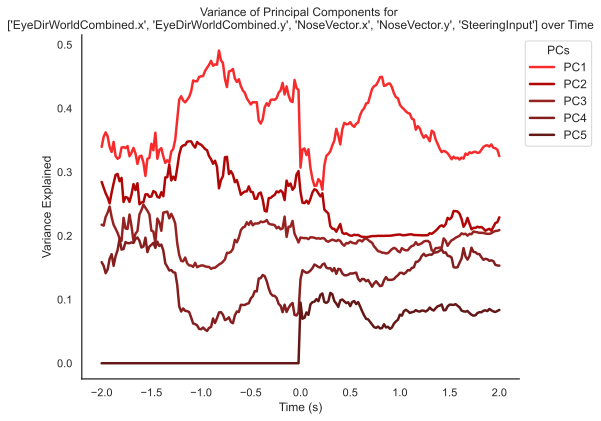

In [162]:
import matplotlib.pyplot as plt

# Example color palette you provided
color_pca = {
    'PC1': '#F72B2B', 'PC2': '#B10606',
    'PC3': '#962222', 'PC4': '#851E1E',
    'PC5': '#641717', 'PC6': '#430F0F',
    # 'PC7': '#3A0E0E', 'PC8': '#320C0C',
    # 'PC9': '#2B0A0A', 'PC10': '#240808'
}

# Select PCs to plot
pcs = ['PC1', 'PC2', 'PC3', 'PC4']#, 'PC5']

fig, ax= plt.subplots(figsize=(8, 6))

sns.lineplot(x='Time', y='pca_value', data=components_df, hue='PCs', linewidth=2.5, linestyle='-', palette=color_pca)
# for pc in pcs:
#     ax.plot(variances_df['Time'], variances_df[pc], label=pc, color=color_pca.get(pc, '#000000'))
# Remove the default legend as we'll create a custom one later
# ax.legend()#.remove()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
sns.despine(ax=ax, offset=0, trim=False)
plt.xlabel('Time (s)')
plt.ylabel('Variance Explained')
plt.title(f'Variance of Principal Components for \n{eye + head + steering} over Time')
# plt.legend(title='Principal Components')
plt.grid(False)
plt.tight_layout()
plt.show()

# Effective dimensionality

In [ ]:
def compute_ED_estimators(eigenvalues):
    """
    Compute Effective Dimensionality estimators from eigenvalues.
    Parameters:
    eigenvalues (list or array): List of eigenvalues.
    Returns:
    dict: Dictionary containing various ED estimators (n1, n2, nInf, nC).
    """
    output = {}

    # Make eigenvalues a numpy array for easier manipulation
    eigen_val = np.array(eigenvalues)

    # Compute ED estimators
    K = len(eigen_val)
    eigen_sum = np.sum(eigen_val)
    norm_eigen_val = eigen_val / eigen_sum

    # Calculate variance using the K/(K-1) adjustment
    eigen_var = np.var(eigen_val, ddof=0) * ((K - 1) / K)

    # Calculate the four different estimators
    output["n1"] = np.prod(norm_eigen_val ** (-norm_eigen_val))
    output["n2"] = (eigen_sum ** 2) / np.sum(eigen_val ** 2)
    output["nInf"] = eigen_sum / np.max(eigen_val)
    output["nC"] = K - ((K ** 2) / (eigen_sum ** 2)) * eigen_var

    return output

# Process eigenvalues_df DataFrame
def calculate_ED(df):
    """
    Process eigenvalues from a DataFrame to compute ED estimators per timestamp.
    Parameters:
    df (DataFrame): A DataFrame containing eigenvalues and a Time column.
    Returns:
    DataFrame: A new DataFrame containing ED estimators and the Time column.
    """
    results = []

    for _, row in df.iterrows():
        # Exclude Time, Event col and handle NaNs (if any)
        eigenvalues = row[:-2].dropna()
        time = row['Time']
        event = row['EventName']
        ed_estimators = compute_ED_estimators(eigenvalues)
        ed_estimators['Time'] = time
        ed_estimators['EventName'] = event
        results.append(ed_estimators)

    # Convert results to a DataFrame
    processed_df = pd.DataFrame(results)
    return processed_df

# Apply function to eigenvalues_df
ed_df = calculate_ED(eigenvalues_df)

# Display the resulting DataFrame
ed_df

In [ ]:
def visualize_effective_dimensionality(ed_df, title="Effective Dimensionality Over Time", features=None, save=False):
    """
    Visualizes effective dimensionality measures through time.

    Parameters:
    - ed_df: DataFrame containing ED estimates with columns ['Time', 'n1', 'n2', 'nInf', 'nC'].
    - title: Title of the plot (default: "Effective Dimensionality Over Time").
    - features: List of features used in the analysis (for title display).
    - save: Whether to save the plot as a file (default: False).

    Returns:
    - None
    """
    # Set style
    sns.set_theme(style="ticks")
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create a mapping for LaTeX-style labels
    label_mapping = {
        'n1': '$n_{1}$',
        'n2': '$n_{2}$',
        'nInf': '$n_{\\infty}$',
        'nC': '$n_{C}$'
    }
    eddf = ed_df.drop(columns=['EventName'], inplace=False)

    # Convert ed_df to long format for lineplot
    ed_long = eddf.melt(id_vars=['Time'], var_name='Estimator', value_name='Value')

    # Map the estimators to their LaTeX-style labels
    ed_long['Estimator'] = ed_long['Estimator'].map(label_mapping)

    # Plot all lines at once, differentiating by hue and style
    # sns.lineplot(data=ed_long, x='Time', y='Value', hue='Estimator', style='Estimator',
    #              palette=sns.color_palette("gray", 4), linewidth=1.5, ax=ax_top)
    sns.lineplot(data=ed_long, x='Time', y='Value', hue='Estimator', style='Estimator',
                 palette=['#2F4858','#D83456', '#586A73', '#86888A'], linewidth=1.5, ax=ax)

    # Apply styling to top plot
    n_features = len(features) -2 # if features is not None else "unknown number of"
    ax.set_title(f"Effective dimensionality over time, {n_features} variables", fontsize=12)
    ax.set_ylabel("Effective Dimensionality", fontsize=10)

    # Hide the x-label on the top plot since we have a shared x-axis
    ax.set_xlabel("")

    # Remove the default legend as we'll create a custom one later
    # ax.get_legend()#.remove()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=12)
    sns.despine(ax=ax, offset=0, trim=False)

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Show the plot
    plt.show()


In [ ]:
visualize_effective_dimensionality(ed_df, features=eigenvalues_df.columns, save=False)


# PCA Videos

In [143]:
import cv2

# Define the base results path
pca_path = "plots/"

# Create base results directory
os.makedirs(pca_path, exist_ok=True)

# Create subdirectories under the base results path
directories = {
    "videos": os.path.join(pca_path, "videos"),
    # "variances": os.path.join(results_path, "variances"),
    # "components": os.path.join(results_path, "components"),
    # "eigenvalues": os.path.join(results_path, "eigenvalues"),
}

# Create each subdirectory
for subdir in directories.values():
    os.makedirs(subdir, exist_ok=True)

images_folder = r'plots/biplot/'
video_name = "PCA_biplot_eye_head_StagEvent_1_7fps.mp4"
fps = 7.0


In [138]:
directories['videos']

'plots/videos'

In [146]:
# Use the biplots images to create a video
def make_video(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    print(images)
    images.sort(key=lambda x: int(x.split('_')[5].split('.')[0]))

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape


    # Use the 'mp4v' codec
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps,
                            (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [147]:
make_video(images_folder, video_name, fps)

IndexError: list index out of range